In [27]:
!pip uninstall numpy matplotlib -y
!pip install numpy matplotlib

Found existing installation: numpy 1.26.3
Uninstalling numpy-1.26.3:
  Successfully uninstalled numpy-1.26.3
Found existing installation: matplotlib 3.8.2
Uninstalling matplotlib-3.8.2:
  Successfully uninstalled matplotlib-3.8.2
  Using cached numpy-1.26.3-cp310-cp310-macosx_10_9_x86_64.whl (20.6 MB)
  Using cached matplotlib-3.8.2-cp310-cp310-macosx_10_12_x86_64.whl (7.6 MB)

[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

In [2]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [3]:
def get_data(pde_name, pde_params, x_metric, y_metric, opts, extensions, entity_name):
    x_val = []
    y_val = []
    opt_val = []  # List to store optimizer names

    api = wandb.Api()

    for opt in opts:
        proj_name = f'{pde_name}_{extensions[opt]}'

        for run in api.runs(f'{entity_name}/{proj_name}'):
            if run.state != 'finished':
                continue
            config = run.config
            if config['pde_params'] == pde_params:
                x_val.append(run.summary[x_metric])
                y_val.append(run.summary[y_metric])
                opt_val.append(opt)  # Store the optimizer used

    return x_val, y_val, opt_val

In [4]:
def get_title(pde_name, pde_params):
    if pde_name == "convection":
        return f'Convection, $\\beta = {pde_params[1]}$'
    if pde_name == "reaction":
        return f'Reaction, $\\rho = {pde_params[1]}$'
    elif pde_name == "reaction_diffusion":
        return f'Reaction-diffusion, $\\nu = {pde_params[1]}, \\rho = {pde_params[3]}$'
    elif pde_name == "wave":
        return f'Wave, $\\beta = {pde_params[1]}$'

In [5]:
def plot_metrics_scatter_multi_pde(pdes, x_metric, y_metrics, opts, extensions, entity_name, opt_names, metric_names, opt_colors, font_size, folder_path, filename):
    mpl.rcParams.update({'font.size': font_size})

    nrows = len(y_metrics)
    ncols = len(pdes)

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

    # Dictionary to hold legend handles
    legend_handles = {opt: plt.Line2D([0], [0], marker='o', color='w', label=opt_names[opt], markersize=10, markerfacecolor=opt_colors[opt]) for opt in opts}

    for row, y_metric in enumerate(y_metrics):
        for col, (pde_name, pde_params) in enumerate(pdes):
            x_val, y_val, opt_val = get_data(pde_name, pde_params, x_metric, y_metric, opts, extensions, entity_name)

            ax = axs[row, col] if nrows > 1 and ncols > 1 else (axs[col] if nrows == 1 else axs[row])

            # Plot each point
            for x, y, opt in zip(x_val, y_val, opt_val):
                ax.scatter(x, y, s=30, c=opt_colors[opt], marker='o', edgecolors='k', linewidths=0)

            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_ylabel(metric_names[y_metric])
            ax.set_xlabel(metric_names[x_metric])
            ax.set_title(get_title(pde_name, pde_params))

    # Use the legend handles
    fig.legend(handles=legend_handles.values(), loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(opts))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    filename = filename + '.pdf'
    fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
    plt.show()

In [6]:
entity_name = 'sketchy-opts'
extensions = {
    'adam': 'adam_final',
    'lbfgs': 'lbfgs_final',
    'adam_lbfgs': 'adam_lbfgs_final',
    'adam_lbfgs_11k': 'adam_lbfgs_final_11k',
    'adam_lbfgs_31k': 'adam_lbfgs_final_31k'
}
opt_names = {
    'adam': 'Adam',
    'lbfgs': 'L-BFGS',
    'adam_lbfgs': 'Adam + L-BFGS (1k)',
    'adam_lbfgs_11k': 'Adam + L-BFGS (11k)',
    'adam_lbfgs_31k': 'Adam + L-BFGS (31k)'
}
opt_colors = {
    'adam': 'tab:blue',
    'lbfgs': 'tab:orange',
    'adam_lbfgs': 'tab:green',
    'adam_lbfgs_11k': 'tab:red',
    'adam_lbfgs_31k': 'tab:purple'
}
metric_names = {
    'train/l2re': 'Training L2RE',
    'train/l1re': 'Training L1RE',
    'test/l2re': 'L2RE',
    'test/l1re': 'Test L1RE',
    'loss': 'Loss'
}

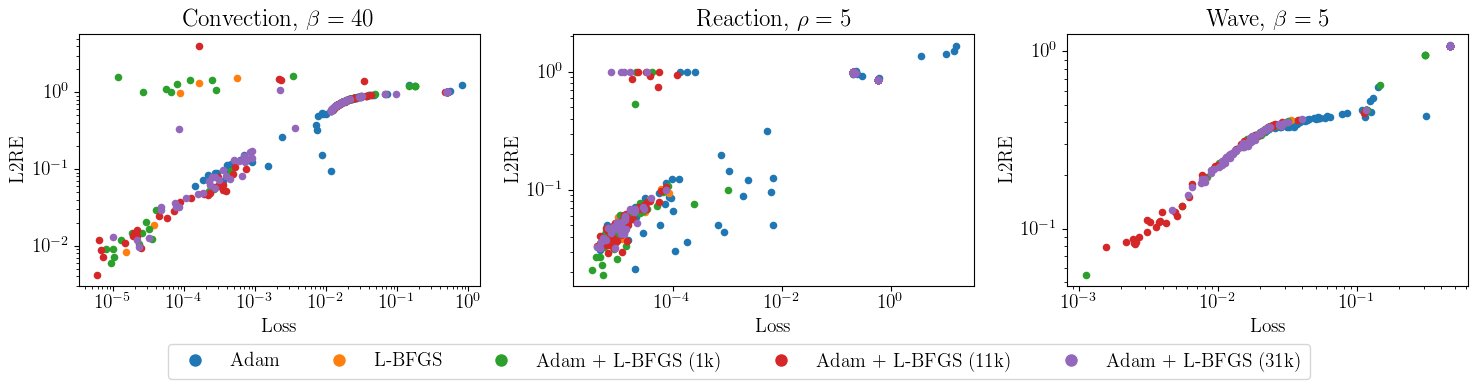

In [7]:
# pdes = [('convection', ['beta', '40']), ('reaction_diffusion', ['nu', '6', 'rho', '5']), ('wave', ['beta', '5'])]
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
x_metric = 'loss'
y_metrics = ['test/l2re']
opts = ['adam', 'lbfgs', 'adam_lbfgs', 'adam_lbfgs_11k', 'adam_lbfgs_31k']
folder_path = 'metric_scatter_plots'
filename = 'scatter_multi_pde'

plot_metrics_scatter_multi_pde(pdes, x_metric, y_metrics, opts, extensions, entity_name, opt_names, metric_names, opt_colors,
                               font_size=14, folder_path='metric_scatter_plots', filename='scatter_multi_pde')